In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import copy
from utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [9]:
batch_size = 64
epochs = 10

results = {}

prune_percentages = [70, 50, 30, 20, 15, 10, 8, 5, 3] 

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])
train_dataset = datasets.CIFAR10(root= '../data/cifar10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root= '../data/cifar10', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def run_experiment():
    global results
    for prune_percentage in prune_percentages:
        print(f"\n{'='*50}")
        print(f"Prunning al {prune_percentage}%")
        print(f"{'='*50}")

        # Crear modelo y guardar estado inicial
        model = create_alexnet().to(device)
        initial_state_dict = model.state_dict()
        
        # Contar parámetros totales
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Parámetros totales: {total_params:,}")

        # Entrenar modelo original
        print("Entrenando modelo original...")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)  # LR más bajo para AlexNet
        train_model(model, train_loader, criterion, optimizer, epochs)
        acc_original = evaluate_model(model, test_loader)
        print(f"Accuracy modelo original: {acc_original:.2%}")

        # Pruneo del modelo
        print("Aplicando pruning...")
        prune_mask = create_prune_mask(model, prune_percentage / 100.0)
        model.load_state_dict(initial_state_dict)  # Reiniciar pesos iniciales
        prune_model(model, prune_mask)

        # Verificar porcentaje de pruning
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        zero_params = sum((p == 0).sum().item() for p in model.parameters() if p.requires_grad)
        actual_prune_percentage = (zero_params / total_params) * 100
        print(f"Porcentaje real de pruning: {actual_prune_percentage:.1f}%")

        # Entrenar modelo pruned con máscara mantenida
        print("Entrenando modelo podado...")
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        train_model_with_mask(model, train_loader, criterion, optimizer, epochs, prune_mask)
        acc_pruned = evaluate_model(model, test_loader)

        # Guardar resultados
        results[prune_percentage] = {
            "accuracy_original": acc_original,
            "accuracy_pruned": acc_pruned,
            "actual_prune_percentage": actual_prune_percentage
        }
        print(f"Accuracy original: {acc_original:.2%}")
        print(f"Accuracy pruned: {acc_pruned:.2%}")
        print(f"Diferencia: {(acc_pruned - acc_original)*100:.2f} puntos porcentuales")

run_experiment()


Prunning al 70%


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Parámetros totales: 57,044,810
Entrenando modelo original...
Accuracy modelo original: 81.77%
Aplicando pruning...
Porcentaje real de pruning: 70.0%
Entrenando modelo podado...
Accuracy original: 81.77%
Accuracy pruned: 84.22%
Diferencia: 2.45 puntos porcentuales

Prunning al 50%
Parámetros totales: 57,044,810
Entrenando modelo original...
Accuracy modelo original: 83.15%
Aplicando pruning...
Porcentaje real de pruning: 50.0%
Entrenando modelo podado...
Accuracy original: 83.15%
Accuracy pruned: 83.96%
Diferencia: 0.81 puntos porcentuales

Prunning al 30%
Parámetros totales: 57,044,810
Entrenando modelo original...
Accuracy modelo original: 82.08%
Aplicando pruning...
Porcentaje real de pruning: 30.0%
Entrenando modelo podado...
Accuracy original: 82.08%
Accuracy pruned: 83.79%
Diferencia: 1.71 puntos porcentuales

Prunning al 20%
Parámetros totales: 57,044,810
Entrenando modelo original...
Accuracy modelo original: 82.71%
Aplicando pruning...
Porcentaje real de pruning: 20.0%
Entrenan

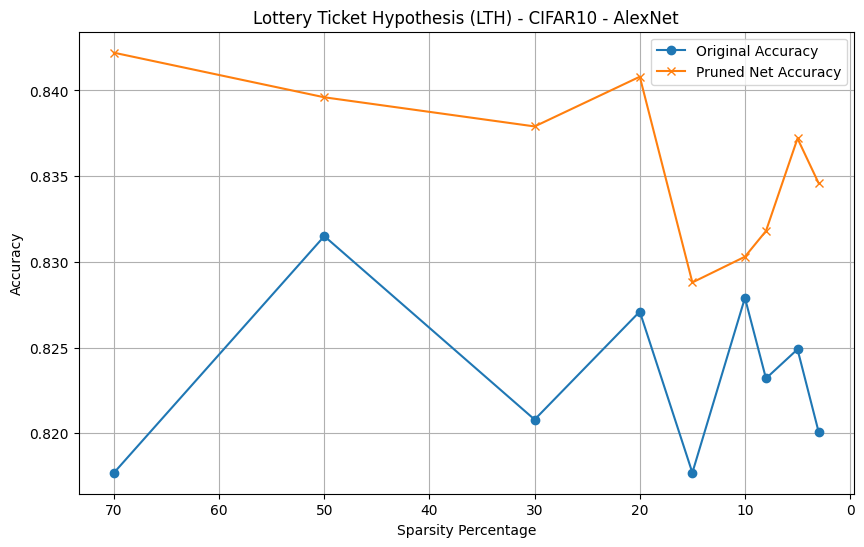

In [ ]:
original_accuracies = [results[p]["accuracy_original"] for p in prune_percentages]
prunned_accuracies = [results[p]["accuracy_pruned"] for p in prune_percentages]

plt.figure(figsize=(10, 6))
plt.plot(prune_percentages, original_accuracies, label="Original Accuracy", marker="o")
plt.plot(prune_percentages, prunned_accuracies, label="Pruned Net Accuracy", marker="x")
plt.gca().invert_xaxis()  # Invertir eje X para visualizar mejor
plt.title("Lottery Ticket Hypothesis (LTH) - CIFAR10 - AlexNet")
plt.xlabel("Sparsity Percentage")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
print(f"\n{'='*60}")
print("RESUMEN FINAL - LOTTERY TICKET HYPOTHESIS")
print(f"{'='*60}")
for p in prune_percentages:
    orig = results[p]["accuracy_original"]
    prun = results[p]["accuracy_pruned"]
    diff = prun - orig
    print(f"Pruning {p:2d}%: Original {orig:.2%} | Pruned {prun:.2%} | Diff {diff*100:+.2f}%")


RESUMEN FINAL - LOTTERY TICKET HYPOTHESIS
Pruning 70%: Original 81.77% | Pruned 84.22% | Diff +2.45%
Pruning 50%: Original 83.15% | Pruned 83.96% | Diff +0.81%
Pruning 30%: Original 82.08% | Pruned 83.79% | Diff +1.71%
Pruning 20%: Original 82.71% | Pruned 84.08% | Diff +1.37%
Pruning 15%: Original 81.77% | Pruned 82.88% | Diff +1.11%
Pruning 10%: Original 82.79% | Pruned 83.03% | Diff +0.24%
Pruning  8%: Original 82.32% | Pruned 83.18% | Diff +0.86%
Pruning  5%: Original 82.49% | Pruned 83.72% | Diff +1.23%
Pruning  3%: Original 82.01% | Pruned 83.46% | Diff +1.45%
